# Specific Task - 2
## description
Classify images into with and without strong lenses.

## Introduction

This Project implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on Strong lense images dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.


## Setup

In [1]:
!pip install -U tensorflow-addons

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os
from astropy.io import fits
from astropy.wcs import WCS

2023-03-27 16:11:06.872259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 16:11:06.997432: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 16:11:06.998847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 16:11:10.554487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supp

## Prepare the data

In [3]:
num_classes = 1
input_shape = (101, 101, 1)


files=[]
for f in os.listdir('lense_finding/SpaceBasedTraining/files'):
    files.append('lense_finding/SpaceBasedTraining/files/'+f)
    
x_data=[]
for file in files:
    with fits.open(file) as hdu:
        data=hdu[0].data
        x_data.append(np.transpose(np.array([data])))
x_data=np.array(x_data)


y_data=[]
data=pd.read_csv('/home/studio-lab-user/ML4S/lense_finding/SpaceBasedTraining/classifications.csv')
y_data=data['is_lens']
y_data=np.array(y_data)


x_train, y_train, x_test, y_test=[], [], [], []
for i in range(5000):
    indx=np.random.choice(range(15000))
    x_train.append(x_data[indx])
    y_train.append(y_data[indx])
print(indx)
    
for i in range(1000):
    indx=np.random.choice(range(15000, 18000))
    x_test.append(x_data[indx])
    y_test.append(y_data[indx])
print(indx)

x_train, y_train, x_test, y_test=np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


10531
17380
x_train shape: (5000, 101, 101, 1) - y_train shape: (5000,)
x_test shape: (1000, 101, 101, 1) - y_test shape: (1000,)


## Configure the hyperparameters

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 100
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2023-03-27 16:12:47.509681: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 204020000 exceeds 10% of free system memory.


## Implement multilayer perceptron (MLP)

In [6]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [7]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


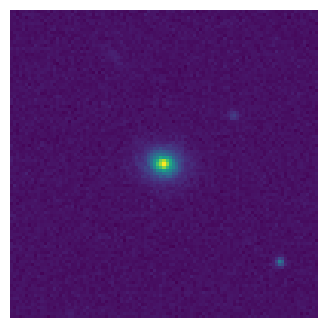

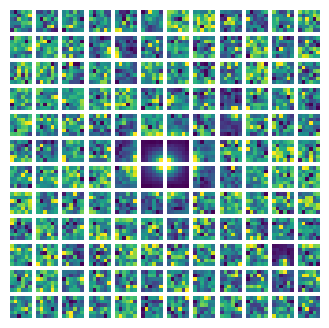

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [9]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model



In [10]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

Epoch 1/10
45/45 [==============================] - 500s 11s/step - loss: 1.9550 - tp: 1971.0000 - fp: 898.0000 - tn: 516.0000 - fn: 1115.0000 - accuracy: 0.5527 - precision: 0.6870 - recall: 0.6387 - auc: 0.5009 - prc: 0.6868 - val_loss: 0.6432 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 146.0000 - val_fn: 354.0000 - val_accuracy: 0.2920 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.7080
Epoch 2/10
45/45 [==============================] - 472s 10s/step - loss: 0.6717 - tp: 2095.0000 - fp: 991.0000 - tn: 423.0000 - fn: 991.0000 - accuracy: 0.5596 - precision: 0.6789 - recall: 0.6789 - auc: 0.4955 - prc: 0.6866 - val_loss: 0.6390 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 146.0000 - val_fn: 354.0000 - val_accuracy: 0.2920 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.7080
Epoch 3/10
45/45 [==============================] - 472s 10s/step - loss: 0.6493 - tp: 2170.0000 - fp: 952.0000 - tn: 462.000

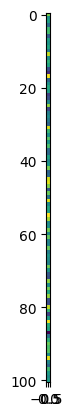

In [17]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=METRICS
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
    )


    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


In [ ]:
vit_classifier.save_weights('checkpoint/')

In [25]:
vit_classifier.load_weights('checkpoint/')
results = vit_classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {round(results[6] * 100, 2)}%")

32/32 [==============================] - 40s 1s/step - loss: 0.6050 - tp: 712.0000 - fp: 288.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.7120 - precision: 0.7120 - recall: 1.0000 - auc: 0.5000 - prc: 0.7120
Test accuracy: 71.2%


32/32 [==============================] - 41s 1s/step


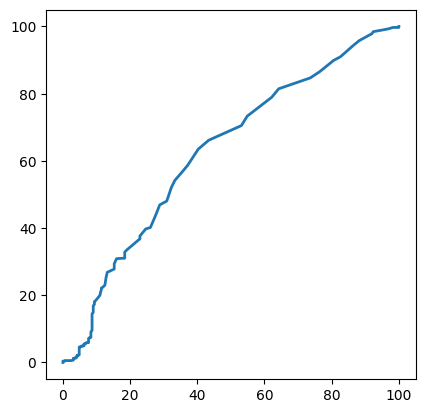

In [26]:
from sklearn import metrics
predictions= vit_classifier.predict(x_test)
fp, tp, _ = metrics.roc_curve(y_test, predictions)
plt.plot(100*fp, 100*tp, linewidth=2)
ax = plt.gca()
ax.set_aspect('equal')